In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

import numpy as np
import json
from collections import defaultdict
from tqdm import tqdm

In [3]:
from configs.default import cfg
import sys

from src.datasets.replica_hard_iou_eval_interface import (
    ReplicaHardIoUDataset,
)
from torch.utils.data import DataLoader

In [4]:
eval_replica_config = "configs/config_eval_replica_spectre.yaml"
cfg.merge_from_file(eval_replica_config)

In [5]:
print(cfg)

DATASET:
  DATA_ROOT: /scratch2/public_scratch/toponav/indoor-topo-loc/datasets/replica-dataset/data
  DATA_SOURCE: Replica
  DINOV2_CACHED_ROOT: None
  HEIGHT: 480
  MAST3RLIKE_CACHED_ROOT: None
  M_PRIME: 100
  PAIRS_PATH: /scratch2/public_scratch/toponav/indoor-topo-loc/datasets/replica-dataset/data/replica_pose_bins_subset.json
  PAIRS_ROOT: None
  RESIZE_H: None
  RESIZE_W: None
  SAM2_CACHED_ROOT: None
  SAM_AMG_ROOT: None
  SCENES: None
  SCENES_VAL: None
  SEGDATA_ROOT: /scratch2/public_scratch/toponav/indoor-topo-loc/datasets/replica-dataset/data
  TRANSFORMS_ROOT: None
  WIDTH: 640
DEBUG: False
FEATURE_MATCHER:
  DUAL_SOFTMAX:
    TEMPERATURE: None
    USE_DUSTBIN: None
  SINKHORN:
    DUSTBIN_SCORE_INIT: 1.0
    NUM_IT: 50
  TYPE: Sinkhorn
MODEL: None
RANDOM_SEED: 42
SAVE_DIR: results/replica_val8_evals
TRAINING:
  ALT_LOSS_WEIGHT: 0
  BATCH_SIZE: 36
  EPOCHS: 20
  GRAD_CLIP: 0.0
  LOG_INTERVAL: None
  LR: 0.0001
  LR_STEP_GAMMA: None
  LR_STEP_INTERVAL: None
  NUM_GPUS: 1
 

In [6]:
START_ANGLE, END_ANGLE = 0, 45
print(f"Evaluating {START_ANGLE} to {END_ANGLE} degrees")

subset_split_file = cfg['DATASET']['PAIRS_PATH']
with open(subset_split_file, "r") as f:
    subset_split = json.load(f)

# build pairs by looking at X-Y split under each scene, ignore if not present
ref_query_pairs = []

for scene_id, scene_data in subset_split.items():
    if f"{START_ANGLE}-{END_ANGLE}" in scene_data:
        for pair_str in scene_data[f"{START_ANGLE}-{END_ANGLE}"]:
            ref, query = pair_str.split("-")
            ref_query_pairs.append((scene_id, ref, query))

# ref_query_pairs = ref_query_pairs[:10] # for testing that the whole pipeline works

# # val_selected_scenes = ["394a542a19", "9f79564dbf", "e8e81396b6"]
# val_dataset = ScanNetPPResizedHardIoUDataset(cfg, val_selected_scenes, None)

val_dataset = ReplicaHardIoUDataset(cfg, None, ref_query_pairs)

Evaluating 0 to 45 degrees
Using overridden ref-query pairs: 2000


 14%|█▍        | 289/2000 [00:20<02:15, 12.66it/s]

GTP is zero at index = 290: GT.shape = (102, 102) | scene_id = 'office_1/Sequence_1' | frame0 = 'rgb_490' | frame1 = 'rgb_780'
img0_path = '/scratch2/public_scratch/toponav/indoor-topo-loc/datasets/replica-dataset/data/office_1/Sequence_1/rgb/rgb_490.png'
img1_path = '/scratch2/public_scratch/toponav/indoor-topo-loc/datasets/replica-dataset/data/office_1/Sequence_1/rgb/rgb_780.png'


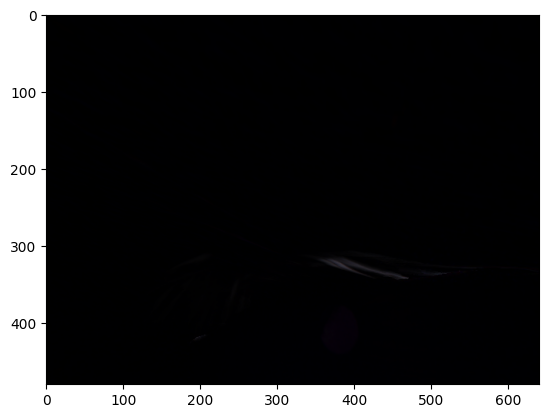

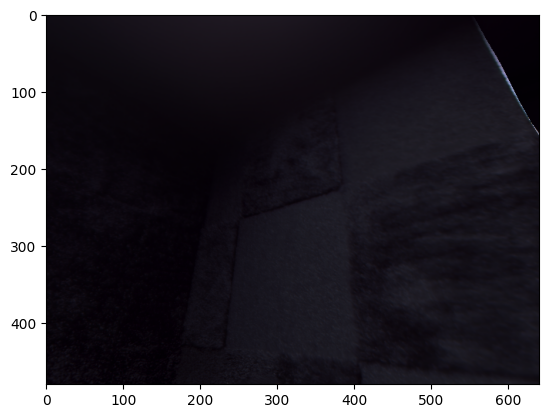

 14%|█▍        | 290/2000 [00:21<02:05, 13.63it/s]


In [13]:
from PIL import Image
import matplotlib.pyplot as plt

for i, data in enumerate(tqdm(val_dataset)):
    # if i > 0:
    #     break
    scene_id = data['scene_id']
    frame0 = data['img0_name']
    frame1 = data['img1_name']
    img0_path = data['img0_path']
    img1_path = data['img1_path']

    gt_mat = torch.diag_embed(data['seg_corr_list_common'])
    gt_mat = gt_mat.detach().cpu().numpy()

    GT = gt_mat.astype("bool")
    GTP = np.count_nonzero(GT.any(0))
    
    if GTP == 0:
        print(f"GTP is zero at index = {i}: {GT.shape = } | {scene_id = } | {frame0 = } | {frame1 = }")
        print(f"{img0_path = }")
        print(f"{img1_path = }")

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        plt.imshow(img0)
        plt.show()

        plt.imshow(img1)
        plt.show()
        break

    